# 특성 선택
- 여러 변환 과정을 거치다 보면 필요 이상으로 필요 없는 특성들이 추가적으로 생길 수 있다.
- 원본 데이터 세트를 가지고 왔는데, 노이즈 데이터가 많을 수도 있다.
- 비즈니스 전문가가 없다면? 엔지니어가 직접 데이터를 정제해야 하는 일들이 생김
    - 어떤게 좋은 데이터고 나쁜 데이터에 대한 확인필요

# 특성 자동 선택
* 일변량 통계 : Unvariable statistics
* 모델 기반 선택 : model-based Selection
* 반복적 선택 : Iterative Selection

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import numpy as np

cancer = load_breast_cancer()

# 난수 발생
np.random.seed(42)
noise = np.random.randn(len(cancer['data']), 50)

cancer['data'].shape, noise.shape

((569, 30), (569, 50))

In [2]:
# 정상 데이터 30개 + 노이즈 데이터 50개 합치기
X_w_noise = np.hstack([cancer['data'], noise])
X_w_noise.shape

(569, 80)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_w_noise,
    cancer['target'],
    random_state=0,
    test_size=.5
)


## 일변량 통계
* 각각의 특성과 타깃 사이에 중요한 통계적 관계가 있는지를 계산한다.
* 깊게 연관되어 있는 특성을 선택한다.
* 분류에서는 **분산 분석**이라고 한다.
* 각 특성이 독립적으로 평가 - **일변량**
* 다른 특성과 깊게 연관된 특성은 선택이 안될 가능이 크다.

----
> 지지도 : 타깃이 특성을 얼마나 지지하는가에 대한 점수(p-값)

* SelectKBest - 지지도가 좋은 K개의 특성만 사용하기
* SelectPercentile - 지정된 비율만큼 특성을 선택


In [8]:
from sklearn.feature_selection import SelectPercentile

# 50%의 데이터만을 사용
# 제일 Best 선택은? 진짜가 30개 + 노이즈가 10개
select = SelectPercentile(percentile=50)
X_train_selected = select.fit_transform(X_train, y_train)

X_train_selected.shape

(284, 40)

In [9]:
# 80개 중 어떤게 선택되었는지를 파악
#    -> 지지도가 높은 피쳐가 선택됨
mask = select.get_support()
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False,  True, False,  True,
       False, False,  True, False, False, False, False,  True, False,
       False,  True, False, False,  True, False,  True, False, False,
       False, False, False, False,  True, False,  True, False, False,
       False, False,  True, False,  True, False, False, False, False,
        True,  True, False,  True, False, False, False, False])

In [10]:
def selected_visualization(selected_mask):
  plt.matshow(selected_mask.reshape(1, -1), cmap='gray_r')
  plt.xlabel("Feature Number")
  plt.yticks([0])
  plt.show()

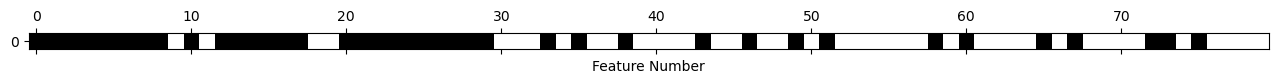

In [11]:
selected_visualization(mask)

# 모델 기반 특성 선택
- 지도학습 머신러닝 모델을 사용해서 특성의 중요도를 평가해서 가장 중요한 특성만 선택
- 특성 선택을 위해 사용하는 머신러닝 모델을 최종적으로 사용할 지도학습 모델과 같을 필요는 없다
- 결정 트리 같은 트리 기반 알고리즘은 중요도를 판단할수 있다.

In [12]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

select = SelectFromModel(
    RandomForestClassifier(n_estimators= 100, random_state=42),
    threshold= 'median'
)

select.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median')

In [15]:
X_train_rf = select.transform(X_train)
X_train_rf.shape

(284, 40)

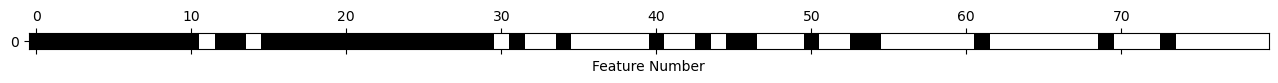

In [14]:
mask = select.get_support()
selected_visualization(mask)

## 반복적 특성 선택
- 특성을 하나도 선택하지 않은 상태로 어떠한 종료 조건에 도달 할 때까지 특성을 하나씩 추가하는 기법
- 모든 특성을 가지고 시작하여 어떤 종료 조건에 도달 할 때까지 특성을 하나씩 제거하는 방법 보통 사용되는 방법
---
- 일단 모델이 만들어지고 시작을 하기 때문에 일변랑 분석, 모델 기반 선택보다 계산 비용이 훨씬 많이 든다.
- 재귀적 특성 제거(Recursive Feature Elimination) 일반적인 방법
    - 모든 특성을 사용해서 모델을 만들고, 특성중요도가 가장 낮은 특성을 하나 제거
    - 제거 되지 않은 특성을 모두 사용해서 또 새로운 모델을 만들어서 테스트
    - 이 과정을 반복

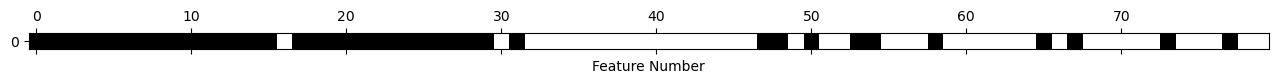

In [16]:
from sklearn.feature_selection import RFE

select = RFE(
    RandomForestClassifier(n_estimators=100, random_state= 42),
    # 재귀 종료 조건. feature가 40개가 될 때 까지 재귀적으로 특성을 제거
    n_features_to_select= 40
)

select.fit(X_train, y_train)

mask = select.get_support()
selected_visualization(mask)